<img src="images/logos/TClogo.png">

### presents

# ROS Developers Extra Class n2

# How to use GPS to do autonomous navigation

This notebook is additional material for the **ROS Developers Extra Class n.2** created and provided for free by Ephson Guarko and Ricardo Tellez of <a href="www.theconstructsim.com">The Construct</a>. You can distribute this notebook as long as you provide copy of this paragraph with it.

## Why this class?

<img src="images/rosa.png">

This class is special because it is specially created for the <a href="http://rosagriculture.org/">ROS Agriculture group</a> (even if anybody is welcomed). The goal is to make agricultural robots move autonomously in the fields following a specific trajectory. This can be applied to the agricultural robots but also to other types of robots like patrol robots, service robots or else. 

Watch the following video by <a href="https://www.youtube.com/channel/UCXRiYTlJu4ag3KiEQkRFdmQ">Kyler Laird</a> about an autonomous tractor moving autonomously on the field.

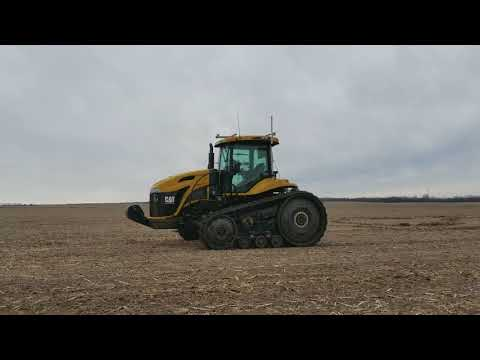

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('XyneZo6KrB4')

### How to use this material
You will need to have a free account at the <a href="http://rds.theconstructsim.com">ROS Development Studio</a>. Get the account and then follow the indications below.

You will also need to watch the Live Class. You can find it here (select next cell of this notebook and press the *play* button):

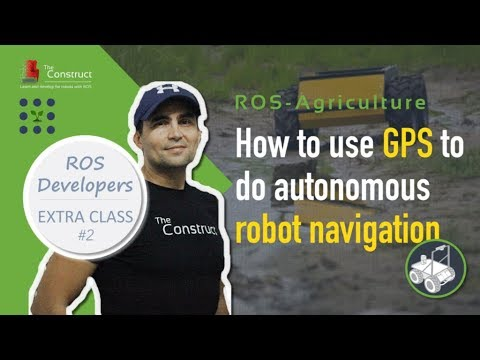

In [2]:
YouTubeVideo('cmOplaq8cHc')

## Today on ROS - EXTRA class n°2, we will be learning about how to:

1. Record an outdoor trajectory we want the robot to reproduce
2. Make the robot reproduce the trajectory autonomously.
3. Everything using GPS
    
I hope you are not overwhelmed already? Don't worry the process is quite simple. The whole process works in 4 steps:

1. Have the robot running
2. Start the GPS based navigation system
3. Record the points
4. Make the robot reproduce the recorded points

## Step 1. Have the robot running

First thing you need to have is the robot with your sensors and actuators working under ROS.

For this class we are going to use a simulation of the Husky robot by Clearpath. Additionally we are going to use some programs already created by Clearpath to show how to do navigation with GPS. We'll see where to modify for your own robot.

- To **start the simulation**, run

In [ ]:
> roslaunch husky_gazebo husky_playpen.launch

You should get something like this:

<img src="images/husky_sim.png">

- Before we do anything, let's check that the robot started correctly by moving it around using our customized 
    keyboard teleop script.

In [ ]:
> rosrun keyboard_control key_teleop.py

**Remember:** having the simulation running is like having the robot. Instead of having the real robot, we have the simulated robot. Hence, as the real robot, the simulation of the robot can do nothing without the proper control programs. So let's see which ROS programs we should launch on the robot in order to make it navigate as we want. The same would apply to the real robot.

## Step 2. Have the navigation system running

We need to launch now the **navigation system based on GPS**. We learnt on the previous Extra Class how to make that system work. You can check the class here (select next cell and press *play*):

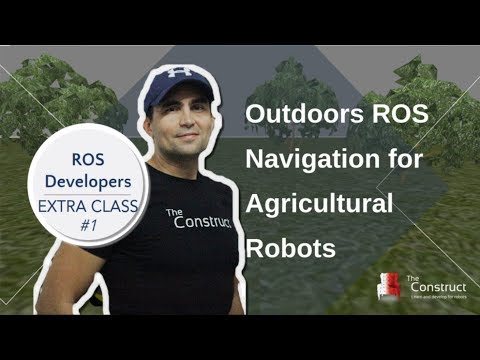

In [3]:
YouTubeVideo('ZomR1tVziLM')

To launch the navigation system type:

In [ ]:
> roslaunch outdoor_waypoint_nav outdoor_nav_sim.launch

This basically is doing:

1. Launching the **map server** with an empty map (to trick the move_base). Remember: only requirements of that **map** are that it **is completely empty**, and that is large enough to cover the whole area you want the robot to move on.

In [ ]:
 <!-- The map file that we are going to use -->
    <arg name="map_file" default="$(find keyboard_control)/maps/floor_map.yaml"/>
    
  <!-- Run map_serserver to provide map -->
    <node name="map_server" pkg="map_server" type="map_server" args="$(arg map_file)" />

2. Launching the **GPS based localization** system using the **robot_localization** package.

In [ ]:
<!-- Launch robot_localization and navsat node-->
    <include file="$(find outdoor_waypoint_nav)/launch/include/localization_run_sim.launch"/>

* The **[robot_localization](https://roscon.ros.org/2015/presentations/robot_localization.pdf) package**. Basically this node integrates data from many sensor sources (wheel encoders, IMU, Barometer, Sonar etc.) into usable format for the robot in ROS.

1. The various data streams are computed using a Kalman filter and combined with the set 'sensor transforms' to produce the **/tf** for the robot.
2. The various data streams are computed using a Kalman filter to produce the **/odom** for the robot.

<img src="images/rbot_loc.png">
     *Image from Tom Moore's presentation at ROSCON2015*

The localization system uses three different instances of **robot_localization**:

* One that **computes the odometry** of the robot using the odometry provided by the encoders of the robot and the IMU.

<node pkg="robot_localization" type="ekf_localization_node" name="ekf_se_odom" clear_params="true"/>

It uses the following configuration (*ekf_params.yaml*):

In [ ]:
ekf_se_odom: # Used only for broadcasting odom to base_link transforms
  frequency: 30
  sensor_timeout: 0.1
  two_d_mode: true
  transform_time_offset: 0.0
  transform_timeout: 0.0
  print_diagnostics: true
  debug: false

  map_frame: map
  odom_frame: odom
  base_link_frame: base_link
  world_frame: odom

# -------------------------------------
# Wheel odometry:

  odom0: /husky_velocity_controller/odom
  odom0_config: [false, false, false,
                 false, false, false,
                 true,  true,  true,
                 false, false, false,
                 false, false, false]
# The order of the boolean values are 
# X,Y,Z,
# roll,pitch,yaw
# X˙,Y˙,Z˙
# roll˙,pitch˙,yaw˙
# X¨,Y¨,Z¨. 
  odom0_queue_size: 10
  odom0_nodelay: true
  odom0_differential: false
  odom0_relative: false

# --------------------------------------
# imu configure:

  imu0: /imu/data
  imu0_config: [false, false, false,
                true,  true,  false,
                false, false, false,
                true,  true,  true,
                true,  true,  true]
  imu0_nodelay: false
  imu0_differential: false
  imu0_relative: false
  imu0_queue_size: 10
  imu0_remove_gravitational_acceleration: true

  use_control: false

  process_noise_covariance: [1e-3, 0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    1e-3, 0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    1e-3, 0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0.3,  0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0.3,  0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0.01, 0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0.5,   0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0.5,   0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0.1,  0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0.3,  0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0.3,  0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0.3,  0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0.3,  0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0.3,  0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0.3]

  initial_estimate_covariance: [1e-9, 0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    1e-9, 0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    1e-9, 0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    1.0,  0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    1.0,  0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    1e-9, 0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    1.0,  0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    1.0,  0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    1.0,  0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    1.0,   0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     1.0,   0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     1.0,   0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     1.0,  0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    1.0,  0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    1.0]


* You can learn how to select those parameters in <a href="http://docs.ros.org/lunar/api/robot_localization/html/configuring_robot_localization.html#configuring-robot-localization">this page of the official documentation</a>. 
* Also, <a href="http://docs.ros.org/lunar/api/robot_localization/html/preparing_sensor_data.html">this page</a> includes a list of best practices when deciding which information to fuse.
* You can see an example of configuration of the **robot_localization** node for odometry calculation by watching this Live Class that shows how to configure to merge IMU with encoder odometry.

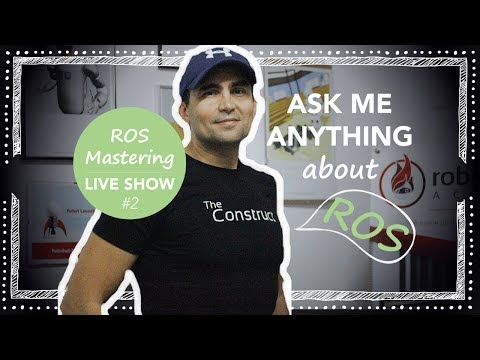

In [4]:
YouTubeVideo('nQZeAafDEJE')

* Another node that does the **localization of the robot** in */map* coordinates. Basically it computes the transform from */map* to */odom*

<node pkg="robot_localization" type="ekf_localization_node" name="ekf_se_map" clear_params="true">
    <remap from="odometry/filtered" to="odometry/filtered_map"/>
  </node>

And this is the configuration for it:

In [ ]:
ekf_se_map:
  frequency: 30
  sensor_timeout: 0.1
  two_d_mode: true
  transform_time_offset: 0.0
  transform_timeout: 0.0
  print_diagnostics: true
  debug: false

  map_frame: map
  odom_frame: odom
  base_link_frame: base_link
  world_frame: map

# -------------------------------------
# Wheel odometry:

  odom0: /husky_velocity_controller/odom
  odom0_config: [false, false, false,
                 false, false, false,
                 true,  true,  true,
                 false, false, true,
                 false, false, false]
  odom0_queue_size: 10
  odom0_nodelay: true
  odom0_differential: false
  odom0_relative: false

# -------------------------------------
# GPS odometry:

  odom1: /outdoor_waypoint_nav/odometry/gps
  odom1_config: [true,  true,  false,
                 false, false, false,
                 false, false, false,
                 false, false, false,
                 false, false, false]
  odom1_queue_size: 10
  odom1_nodelay: true
  odom1_differential: false
  odom1_relative: false

# --------------------------------------
# imu configure:

  imu0: /imu/data
  imu0_config: [false, false, false,
                true,  true, false,
                false, false, false,
                true,  true,  true,
                true,  true,  true]
  imu0_nodelay: true
  imu0_differential: false
  imu0_relative: false
  imu0_queue_size: 10
  imu0_remove_gravitational_acceleration: true

  use_control: false

  process_noise_covariance: [1.0,  0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    1.0,  0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    1e-3, 0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0.3,  0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0.3,  0,    0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0.01, 0,     0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0.5,   0,     0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0.5,   0,    0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0.1,  0,    0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0.3,  0,    0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0.3,  0,    0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0.3,  0,    0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0.3,  0,    0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0.3,  0,
                             0,    0,    0,    0,    0,    0,    0,     0,     0,    0,    0,    0,    0,    0,    0.3]

  initial_estimate_covariance: [1.0,  0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    1.0,  0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    1e-9, 0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    1.0,  0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    1.0,  0,    0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    1e-9, 0,    0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    1.0,  0,    0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    1.0,  0,    0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    1.0,  0,     0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    1.0,   0,     0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     1.0,   0,     0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     1.0,   0,    0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     1.0,  0,    0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    1.0,  0,
                                0,    0,    0,    0,    0,    0,    0,    0,    0,    0,     0,     0,     0,    0,    1.0]


* Another node that computes provides the mechanisms to **transform a GPS coordinate to a */map* coordinate**

<node pkg="robot_localization" type="navsat_transform_node" name="navsat_transform" clear_params="true" output="screen" >
      <remap from="odometry/filtered" to="odometry/filtered_map"/>
      <remap from="gps/fix" to="/navsat/fix"/>
      <remap from="imu/data" to="/imu/data"/>
</node>

The **navsat_transform_node**: This node basically does two things:

* Converts GPS data to UTM coordinate system.
* Publishes a transform from */utm* to */map*
    
It uses the received **GPS data**, **IMU data** and **odometry**

* **Universal Transverse Mercator(UTM)** Coordinate system uses a 2-dimensional Cartesian coordinate system to give locations on the surface of the Earth. [More here](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)

<img src="images/transforms.png">

The configuration parameters for this node are the following (you can get an explanation of their meaning in <a href="http://docs.ros.org/api/robot_localization/html/navsat_transform_node.html">this documentation page</a>):

In [ ]:
navsat_transform:
  frequency: 30
  delay: 3.0
  magnetic_declination_radians: 0.00  #0.168285  # For lat/long 43.500718, -80.546638 on Jun 1 2017
  yaw_offset: 1.570796327  # IMU reads 0 facing magnetic north, not east
  zero_altitude: true
  broadcast_utm_transform: true
  publish_filtered_gps: true
  use_odometry_yaw: false
  wait_for_datum: false


3. Launches the node that makes the robot move using **path planning** and **obstacle avoidance**. That is the **move_base** node.

In [ ]:
<!-- Run husky_navigation to start move_base -->
    <include file="$(find husky_navigation)/launch/move_base_nav.launch" />

## Step 3. Record a trajectory 

* Now to collect waypoints(gps coordinates), drive the robot using the **key_teleop shell** that you launched above, and press the **y-key** to save the current robot location as a waypoint of the trajectory.

You can also launch the following command, to view the corresponding latitudes and longitudes of the robot as you drive around.

In [ ]:
> rostopic echo /outdoor_waypoint_nav/gps/filtered

* The points that you are collecting are stored in the file:
  *~/outdoor_waypoint_nav/waypoint_files/points_sim.txt*

Here there is no mistery at all about what are we doing. The whole process of collecting the points is done in the *key_teleop.py* file, and it works as follows:

* The node subscribes to the */outdoor_waypoint_nav/gps/filtered* topic. That is the one that is providing the coordinates of the robot in UTM.
* Everytime you press the y-key, the current UTM coordinates are stored in the *points_sim.txt* file

The big work is done by the localization system that we launched on the previous section, that is, to get the robot localized on the environment using the GPS.

## Step 4. Reproduce the recorded trajectory

Whenever you are happy with the number of points you have, you are now ready to try to reproduce them. For that, you just have to launch the following package:

In [ ]:
> roslaunch outdoor_waypoint_nav send_goals_sim.launch

This executes the node *gps_waypoint* described in *gps_waypoint.cpp* C++ file.

### What does this node do?

1. Reads a value from the file of points
2. Converts that point from long/lat to *UTM* frame
3. Converts the point from *UTM* to *odom* point
4. Sends the map point as a goal to the *move_base* navigation system (that we have launched in the navigation section above)

#### Transforming from long/lat to UTM

We use a provided library by RobotLocalization that allows us to do the conversion.

In [ ]:
RobotLocalization::NavsatConversions::LLtoUTM(lati_input, longi_input, utm_y, utm_x, utm_zone);

##### In Python that would be

In [ ]:
import geonav_transform.geonav_conversions as gc
utmy, utmx, utmzone = gc.LLtoUTM(p.lat,p.lon)

#### Transforming from UTM to odom

Since the UTM point is inside the */tf* full frame, we can ask ROS TF to transfor from one frame of TF (the */utm* frame) to another frame (the */odom* frame).

In [ ]:
listener.waitForTransform("odom", "utm", time_now, ros::Duration(3.0));
listener.transformPoint("odom", UTM_input, map_point_output);

##### In Python that would be

In [ ]:
import geonav_transform.geonav_conversions as gc
# Define a local origin, latitude and longitude in decimal degrees
# GPS Origin
olat = 49.9
olon = 8.9
xg2, yg2 = gc.ll2xy(p.lat,p.lon,olat,olon)

#### Create a *move_base* navigation goal

We convert the point in */odom* frame into a goal that the normal ROS navigation system can understand (a *move_base* goal) and we send the goal to it, so it will make the robot move around.

In [ ]:
MoveBaseClient ac("/move_base", true);

move_base_msgs::MoveBaseGoal goal = buildGoal(map_point, map_next, final_point);

ac.sendGoal(goal); //push goal to move_base node

//Wait for result
ac.waitForResult();

* Mission completed!!

# If you want to learn more!

We have an online academy that teaches you more about how to make robots navigate with ROS using GPS or laser sensors. Check the following related courses:
* <a href="https://goo.gl/iog3x9">Mastering with ROS: Summit XL robot</a>
* <a href="https://goo.gl/W19qAW">Mastering with ROS: Jackal robot</a>
* <a href="https://goo.gl/9rJq29">ROS Navigation in 5 days</a>

Just check our academy: the <a href="https://goo.gl/7ApVAp">Robot Ignite Academy</a>

 <a href="https://goo.gl/7ApVAp"><img src="images/logos/RIAlogo.png"></a>

## DISCOUNT COUPON 10% (valid until 15th of May 2018): D84FEFFC


## Additional Useful Information 

* More information about the software package used here can be found in the web of the creators, Clearpath Robotics: <a href="http://www.clearpathrobotics.com/assets/guides/husky/HuskyGPSWaypointNav.html">Husky Outdoor GPS Waypoint Navigation</a>

* A Python example of following a trajectory of GPS points (GPS points are stored in a var inside the code). This is just a proof of concept

In [2]:
#! /usr/bin/env python

import rospy
import time
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal, MoveBaseResult, MoveBaseFeedback

# Import geonav tranformation module
import geonav_transform.geonav_conversions as gc
reload(gc)
# Import AlvinXY transformation module
import alvinxy.alvinxy as axy
reload(axy)
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_from_euler
from geometry_msgs.msg import Pose, Quaternion

"""
class SimpleGoalState:
    PENDING = 0
    ACTIVE = 1
    DONE = 2
    WARN = 3
    ERROR = 4

"""
# We create some constants with the corresponing vaules from the SimpleGoalState class
PENDING = 0
ACTIVE = 1
DONE = 2
WARN = 3
ERROR = 4

"""
/move_base/goal
### PYTHON MESSAGE

rosmsg show move_base_msgs/MoveBaseGoal                                                          
geometry_msgs/PoseStamped target_pose                                                                                          
  std_msgs/Header header                                                                                                       
    uint32 seq                                                                                                                 
    time stamp                                                                                                                 
    string frame_id                                                                                                            
  geometry_msgs/Pose pose                                                                                                      
    geometry_msgs/Point position                                                                                               
      float64 x                                                                                                                
      float64 y                                                                                                                
      float64 z                                                                                                                
    geometry_msgs/Quaternion orientation                                                                                       
      float64 x                                                                                                                
      float64 y                                                                                                                
      float64 z                                                                                                                
      float64 w                                                                                                                
               


/move_base/cancel                                                                                                                                                         
/move_base/cmd_vel                                                                                                                                                        
/move_base/current_goal                                                                                                                                                   
/move_base/feedback
"""

# definition of the feedback callback. This will be called when feedback
# is received from the action server
# it just prints a message indicating a new message has been received
def feedback_callback(feedback):
    rospy.loginfo(str(feedback))

def get_xy_based_on_lat_long(p):
    # Define a local orgin, latitude and longitude in decimal degrees
    # GPS Origin
    olat = 49.9
    olon = 8.9
    
    xg2, yg2 = gc.ll2xy(p.lat,p.lon,olat,olon)
    utmy, utmx, utmzone = gc.LLtoUTM(p.lat,p.lon)
    xa,ya = axy.ll2xy(p.lat,p.lon,olat,olon)

    rospy.loginfo("#########  "+p.name+"  ###########")  
    rospy.loginfo("LAT COORDINATES ==>"+str(p.lat)+","+str(p.lon))  
    rospy.loginfo("COORDINATES XYZ ==>"+str(xg2)+","+str(yg2))
    rospy.loginfo("COORDINATES AXY==>"+str(xa)+","+str(ya))
    rospy.loginfo("COORDINATES UTM==>"+str(utmx)+","+str(utmy))

    quaternion = tf.transformations.quaternion_from_euler(0.0, 0.0, p.theta)
    pose = Pose()
    pose.position.x = xg2
    pose.position.y = yg2
    q = Quaternion()
    q.x = quaternion[0]
    q.y = quaternion[1]
    q.z = quaternion[2]
    q.w = quaternion[3]
    pose.orientation = q
    return pose


class gps_point:
    lat = 0.0
    lon = 0.0
    theta= 0.0
    name="MAP"

# initializes the action client node
rospy.init_node('move_base_gps_node')

action_server_name = '/move_base'
client = actionlib.SimpleActionClient(action_server_name, MoveBaseAction)

# waits until the action server is up and running
rospy.loginfo('Waiting for action Server '+action_server_name)
client.wait_for_server()
rospy.loginfo('Action Server Found...'+action_server_name)

points=[]
p=gps_point()
p.lat=49.8999181588
p.lon=8.89996774369
points.append(p)
p.lat=49.7000059083
p.lon=8.89999871302
points.append(p)

n = -1
rate = rospy.Rate(1)

while n < len(points) -1:
    print "===========" + str(len(points))    
    n += 1
    rospy.loginfo("GOING TO POINT N. "+str(n))
    next_point = points[n]
    
    # creates a goal to send to the action server
    goal = MoveBaseGoal()
    
    goal.target_pose.header.frame_id = "/map"
    goal.target_pose.header.stamp    = rospy.get_rostime()
    goal.target_pose.pose = get_xy_based_on_lat_long(next_point)
    
    client.send_goal(goal, feedback_cb=feedback_callback)
    
    # You can access the SimpleAction Variable "simple_state", that will be 1 if active, and 2 when finished.
    #Its a variable, better use a function like get_state.
    #state = client.simple_state
    # state_result will give the FINAL STATE. Will be 1 when Active, and 2 if NO ERROR, 3 If Any Warning, and 3 if ERROR
    
    state_result = client.get_state()
    
    rospy.loginfo("state_result: "+str(state_result))
    
    while state_result < DONE:
        rospy.loginfo("Doing Stuff while waiting for the Server to give a result....")
        rate.sleep()
        state_result = client.get_state()
        rospy.loginfo("state_result: "+str(state_result))
        
    rospy.loginfo("[Result] State: "+str(state_result))
    if state_result == ERROR:
        rospy.logerr("Something went wrong in the Server Side")
    if state_result == WARN:
        rospy.logwarn("There is a warning in the Server Side")

#rospy.loginfo("[Result] State: "+str(client.get_result()))

ImportError: No module named geonav_transform.geonav_conversions